In [20]:
import tqdm
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

from dateutil import parser
from sklearn.metrics import f1_score
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, KFold

np.random.seed(4242)

In [2]:
%time df = pd.read_csv('dataset/dataset_no_2018.csv', encoding='cp1251', parse_dates=['date'])
df.drop('Unnamed: 0', axis=1, inplace=True)
stops = pd.read_csv('dataset/stops.csv', parse_dates=['date'])
df.shape, stops.shape

CPU times: user 48.3 s, sys: 2.25 s, total: 50.5 s
Wall time: 50.6 s


((3153599, 44), (47, 2))

In [ ]:
columns_in = [
    'H2.C3..КОНТР.СООТН...212AIC008.PV', 
    'RF.21304.Ток...213MII904A',
    'S.C.ВПУСК.ПП.ДАВЛ...214PI226AA',
    'S.C.ВПУСК.ПП.ДАВЛ...214PI226AB',
    'SPEED.CONTROLLER...250MSIC001.PV',
    'НАГНЕТАНИЕ.В.EX.21401...250PI001',
    'ПОЛОЖ.НОЖА..ГРАНУЛЯТОРА...214ZI211A',
    'ПОЛОЖ.ЩЕЛ.ДИСКА...214ZI202A',
    'РАСХОД.В....EX.21401...250FIC001.PV',
    'РАСХОД.ЛИНИИ.P.W...214FI205A',
    'ТОК.ДВИГ.ГРАНУЛЯТ...214II217A',
    'УПРАВЛЕНИЕ..P.25001A...250HIC001A',
    'ФАКТ.РАСХОД.ПРОП...213FY070',
    'ЭКСТР.ДВИГ.ПОТОК...214II200A'
]


df[columns_in] = (df[columns_in] - df[columns_in].min(axis=0)) / (df[columns_in].max(axis=0) - df[columns_in].min(axis=0))
calm = ((df[columns_in].diff() > 0.05).sum(axis=1) == 0).astype(int)

In [3]:
M_NEW_DATE_SPAN = 20
M_PRED_BEFORE_SPAN = 5
M_TOP_BOUND_SPAN = 10

new_dates = []
for stop_dt in stops.date[:-1]:
    new_dates.append(stop_dt - timedelta(minutes=M_NEW_DATE_SPAN))
    new_dates.append(stop_dt - timedelta(minutes=2 * M_NEW_DATE_SPAN))
    new_dates.append(stop_dt - timedelta(minutes=3 * M_NEW_DATE_SPAN))
    
new_stops = pd.DataFrame([[dt, 'stop'] for dt in new_dates], columns=stops.columns)
stops = pd.concat([stops.iloc[:-1], new_stops], axis=0)
stops.shape

(184, 2)

In [6]:
df_no_stops = df.copy()
for stop_dt in tqdm.tqdm(stops.date):
    date_range = (df_no_stops.date >= (stop_dt - timedelta(minutes=4 * M_NEW_DATE_SPAN))) \
        & (df_no_stops.date <= (stop_dt + timedelta(minutes=3 * M_NEW_DATE_SPAN)))
    df_no_stops = df_no_stops[~date_range]

df_no_stops.shape

100%|██████████| 184/184 [02:40<00:00,  1.15it/s]


(3099681, 44)

In [7]:
def make_features(df, periods=[1, 3, 10, 30, 50]):  # < M_TOP_BOUND_SPAN = 10 min
    columns = df.columns[df.columns != 'date']
    names = []
    vecs = []
    for period in periods:
        feats = [
            ('mean', df[-period:][columns].mean(axis=0).values),
            ('min', df[-period:][columns].min(axis=0).values),
            ('std', df[-period:][columns].std(axis=0).values),
            ('razd', df[-period - 1:][columns].diff().mean(axis=0).values)
        ]
        
        fs = []
        for f_name, f in feats:
            names.extend(f'{f_name}_{c}_{period}' for c in columns)
            fs.append(f)
        
        vecs.append(np.hstack(fs))
    
    return names, np.hstack(vecs)


NAMES = make_features(df)[0]

In [11]:
def make_range(df, stop_dt):
    return (df['date'] >= (stop_dt - timedelta(minutes=M_TOP_BOUND_SPAN))) & (df['date'] < stop_dt)


def make_false(df_no_stops, n_samples):
    random_work = np.random.choice(df_no_stops.shape[0], n_samples)
    xs = []
    ys = []
    for work in tqdm.tqdm(random_work):
        rng = df_no_stops[make_range(df_no_stops, df_no_stops.iloc[work]['date'] - timedelta(minutes=M_PRED_BEFORE_SPAN))]
        feature_vector = make_features(rng)[1]
        xs.append(feature_vector)
        ys.append(0)
    
    return np.array(xs), np.array(ys)

X_false, y_false = make_false(df_no_stops, 2000)
X_false.shape, y_false.shape

100%|██████████| 2000/2000 [02:18<00:00, 14.45it/s]


((2000, 860), (2000,))

In [12]:
def make_true(df_with_stops, stops):
    xs = []
    ys = []
    for stop_dt in tqdm.tqdm(stops.date):
        rng = df_with_stops[make_range(df_with_stops, stop_dt - timedelta(minutes=M_PRED_BEFORE_SPAN))]
        feature_vector = make_features(rng)[1]
        xs.append(feature_vector)
        ys.append(1)
    
    return np.array(xs), np.array(ys)

X_true, y_true = make_true(df, stops)
X_false.shape, X_true.shape

100%|██████████| 184/184 [00:13<00:00, 13.76it/s]


((2000, 860), (184, 860))

In [13]:
X = np.vstack([X_false, X_true])
y = np.hstack([y_false, y_true]).T
X.shape, y.shape

((2184, 860), (2184,))

In [14]:
def downsampling(X, y):
    ids0, ids1 = y[y == 0].index, y[y == 1].index
    sampled_ids1 = y[y == 1].sample(len(ids0)).index
    nX = pd.concat([X.loc[ids0], X.loc[sampled_ids1]], axis=0)
    ny = pd.concat([y[ids0], y[sampled_ids1]], axis=0)
    assert (nX.index == ny.index).all()
    return nX, ny


def upsampling120(X, y):
    X, y = pd.DataFrame(X), pd.Series(y)
    ids0, ids1 = y[y == 0].index, y[y == 1].index
    n = len(ids0)
    sampled_ids1 = y[y == 1].sample(n, replace=True).index
    index = np.arange(y.index.max() + 1, y.index.max() + n + 1)
    nX = X.loc[sampled_ids1]
    nX.index = index
    nX = pd.concat([nX, X.loc[ids0]], axis=0)
    ny = pd.concat([pd.Series(y[sampled_ids1].as_matrix(), index=index), y[ids0]], axis=0)
    assert (nX.index == ny.index).all()
    return nX.as_matrix(), ny.as_matrix()


def good_upsampling(X, y):
    X_false, X_true = X[y == 0], X[y == 1]
    y_false, y_true = y[y == 0], y[y == 1]
    ids = pd.Series(np.arange(len(X_true))).sample(len(X_false), replace=True).index
    X = np.vstack([X_false, X_true[ids]])
    y = np.hstack([y_false, y_true[ids]]).T
    return X, y

In [15]:
def make_train_val(X, y, n_folds):
    if n_folds == 1:
        return (train_test_split(X, y),)
    else:
        skf = StratifiedKFold(n_splits=n_folds)
        return ((X[train_index], X[test_index], y[train_index], y[test_index]) 
                for train_index, test_index in skf.split(X, y))

In [16]:
test_size = 0.0
n_splits = 1
n_folds = 3
max_rounds = 10000
params = {
    'num_leaves': 2 ** 5 - 1,
    'objective': 'binary',
    'max_depth': 6,
    'min_data_in_leaf': 50,
    'learning_rate': 1e-3,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 1,
    'metric': 'binary',
    'num_threads': 4,
#         'is_unbalanced': True
    'scale_pos_weight': 4
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
if n_splits == 1:
    inds = [np.arange(len(X_train))]
else:
    X_train, y_train = pd.DataFrame(X_train), pd.Series(y_train)
    X_false, X_true = X_train[y_train == 0], X_train[y_train == 1]
    y_false, y_true = y_train[y_train == 0], y_train[y_train == 1]
    
    inds = np.arange(len(X_false))
    np.random.shuffle(inds)
    inds = np.array_split(inds, n_splits)
    inds = [np.hstack([
        X_false.iloc[i_ind].index.values, 
        X_true.index.values
    ]) for i_ind in inds]
    
    X_train, y_train = X_train.as_matrix(), y_train.as_matrix()

predicted = []
f_scores = []
for i, train_index in enumerate(inds):
    X_train1, y_train1 = X_train[train_index], y_train[train_index]
    
    i_f_scores = []
    for X_train2, X_val, y_train2, y_val in make_train_val(X_train1, y_train1, n_folds):
        X_train2, y_train2 = good_upsampling(X_train2, y_train2)

        dtrain = lgb.Dataset(
            X_train2, label=y_train2,
            categorical_feature=[]
        )

        dval = lgb.Dataset(
            X_val, label=y_val, reference=dtrain,
            categorical_feature=[]
        )

        bst = lgb.train(
            params, dtrain, num_boost_round=max_rounds,
            valid_sets=[dtrain, dval], early_stopping_rounds=200, verbose_eval=50
        )
        
        y_pred = (bst.predict(X_val, num_iteration=bst.best_iteration or max_rounds)> 0.5).astype(int)
        i_f_scores.append(fbeta_score(y_val, y_pred))
        predicted.append(bst.predict(X_test, num_iteration=bst.best_iteration or max_rounds))
    
    print(i_f_scores)
    f_scores.append(np.mean(i_f_scores))

# Metrics
model = bst
print('---------------------')
print(f'f_scores: {f_scores}')
if test_size > 0:
    y_pred = (np.mean(predicted, axis=0) > 0.5).astype(int)
    print(f'test f1 score: {fbeta_score(y_test, y_pred)}')

/home/s_belyaev/miniconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[50]	training's binary_logloss: 0.667365	valid_1's binary_logloss: 0.681038
[100]	training's binary_logloss: 0.642701	valid_1's binary_logloss: 0.668042
[150]	training's binary_logloss: 0.620799	valid_1's binary_logloss: 0.657826
[200]	training's binary_logloss: 0.600448	valid_1's binary_logloss: 0.648048
[250]	training's binary_logloss: 0.581451	valid_1's binary_logloss: 0.638903
[300]	training's binary_logloss: 0.563913	valid_1's binary_logloss: 0.630551
[350]	training's binary_logloss: 0.54753	valid_1's binary_logloss: 0.622676
[400]	training's binary_logloss: 0.531704	valid_1's binary_logloss: 0.614749
[450]	training's binary_logloss: 0.517749	valid_1's binary_logloss: 0.608589
[500]	training's binary_logloss: 0.503685	valid_1's binary_logloss: 0.601491
[550]	training's binary_logloss: 0.491173	valid_1's binary_logloss: 0.59561
[600]	training's binary_logloss: 0.477763	valid_1's binary_logloss: 0.587786
[650]	training's

[5300]	training's binary_logloss: 0.0715542	valid_1's binary_logloss: 0.225751
[5350]	training's binary_logloss: 0.0701983	valid_1's binary_logloss: 0.223984
[5400]	training's binary_logloss: 0.0689476	valid_1's binary_logloss: 0.222473
[5450]	training's binary_logloss: 0.0676059	valid_1's binary_logloss: 0.220647
[5500]	training's binary_logloss: 0.0663436	valid_1's binary_logloss: 0.21908
[5550]	training's binary_logloss: 0.0649989	valid_1's binary_logloss: 0.217356
[5600]	training's binary_logloss: 0.0637759	valid_1's binary_logloss: 0.215841
[5650]	training's binary_logloss: 0.0625365	valid_1's binary_logloss: 0.214216
[5700]	training's binary_logloss: 0.0613409	valid_1's binary_logloss: 0.212747
[5750]	training's binary_logloss: 0.0602051	valid_1's binary_logloss: 0.211327
[5800]	training's binary_logloss: 0.0589581	valid_1's binary_logloss: 0.209657
[5850]	training's binary_logloss: 0.0577826	valid_1's binary_logloss: 0.208198
[5900]	training's binary_logloss: 0.05666	valid_1's b

[400]	training's binary_logloss: 0.523637	valid_1's binary_logloss: 0.600909
[450]	training's binary_logloss: 0.508597	valid_1's binary_logloss: 0.592753
[500]	training's binary_logloss: 0.494288	valid_1's binary_logloss: 0.585034
[550]	training's binary_logloss: 0.479964	valid_1's binary_logloss: 0.576364
[600]	training's binary_logloss: 0.467305	valid_1's binary_logloss: 0.569314
[650]	training's binary_logloss: 0.455214	valid_1's binary_logloss: 0.562617
[700]	training's binary_logloss: 0.444008	valid_1's binary_logloss: 0.556517
[750]	training's binary_logloss: 0.433636	valid_1's binary_logloss: 0.550783
[800]	training's binary_logloss: 0.423365	valid_1's binary_logloss: 0.545039
[850]	training's binary_logloss: 0.413696	valid_1's binary_logloss: 0.539419
[900]	training's binary_logloss: 0.40402	valid_1's binary_logloss: 0.533589
[950]	training's binary_logloss: 0.394964	valid_1's binary_logloss: 0.528054
[1000]	training's binary_logloss: 0.386523	valid_1's binary_logloss: 0.522932

[5700]	training's binary_logloss: 0.055241	valid_1's binary_logloss: 0.228552
[5750]	training's binary_logloss: 0.0540551	valid_1's binary_logloss: 0.227523
[5800]	training's binary_logloss: 0.0529258	valid_1's binary_logloss: 0.226614
[5850]	training's binary_logloss: 0.0518416	valid_1's binary_logloss: 0.225704
[5900]	training's binary_logloss: 0.0507628	valid_1's binary_logloss: 0.224782
[5950]	training's binary_logloss: 0.0496358	valid_1's binary_logloss: 0.223863
[6000]	training's binary_logloss: 0.0485721	valid_1's binary_logloss: 0.223056
[6050]	training's binary_logloss: 0.0475297	valid_1's binary_logloss: 0.222304
[6100]	training's binary_logloss: 0.0465463	valid_1's binary_logloss: 0.221457
[6150]	training's binary_logloss: 0.0455658	valid_1's binary_logloss: 0.220663
[6200]	training's binary_logloss: 0.0445475	valid_1's binary_logloss: 0.219836
[6250]	training's binary_logloss: 0.0435748	valid_1's binary_logloss: 0.219095
[6300]	training's binary_logloss: 0.0426621	valid_1's

[1700]	training's binary_logloss: 0.315808	valid_1's binary_logloss: 0.487947
[1750]	training's binary_logloss: 0.30858	valid_1's binary_logloss: 0.480868
[1800]	training's binary_logloss: 0.302319	valid_1's binary_logloss: 0.474861
[1850]	training's binary_logloss: 0.295874	valid_1's binary_logloss: 0.468472
[1900]	training's binary_logloss: 0.289783	valid_1's binary_logloss: 0.462507
[1950]	training's binary_logloss: 0.283595	valid_1's binary_logloss: 0.456028
[2000]	training's binary_logloss: 0.277762	valid_1's binary_logloss: 0.450359
[2050]	training's binary_logloss: 0.271899	valid_1's binary_logloss: 0.444394
[2100]	training's binary_logloss: 0.266411	valid_1's binary_logloss: 0.438799
[2150]	training's binary_logloss: 0.260863	valid_1's binary_logloss: 0.43296
[2200]	training's binary_logloss: 0.255573	valid_1's binary_logloss: 0.427465
[2250]	training's binary_logloss: 0.250138	valid_1's binary_logloss: 0.421848
[2300]	training's binary_logloss: 0.245209	valid_1's binary_loglos

[6950]	training's binary_logloss: 0.036162	valid_1's binary_logloss: 0.177358
[7000]	training's binary_logloss: 0.0354283	valid_1's binary_logloss: 0.176473
[7050]	training's binary_logloss: 0.0346905	valid_1's binary_logloss: 0.175544
[7100]	training's binary_logloss: 0.0339636	valid_1's binary_logloss: 0.174644
[7150]	training's binary_logloss: 0.0332568	valid_1's binary_logloss: 0.173745
[7200]	training's binary_logloss: 0.0325937	valid_1's binary_logloss: 0.172933
[7250]	training's binary_logloss: 0.0319402	valid_1's binary_logloss: 0.172172
[7300]	training's binary_logloss: 0.0313027	valid_1's binary_logloss: 0.171437
[7350]	training's binary_logloss: 0.0306541	valid_1's binary_logloss: 0.170681
[7400]	training's binary_logloss: 0.0300678	valid_1's binary_logloss: 0.170001
[7450]	training's binary_logloss: 0.0294667	valid_1's binary_logloss: 0.16933
[7500]	training's binary_logloss: 0.0288885	valid_1's binary_logloss: 0.168643
[7550]	training's binary_logloss: 0.028303	valid_1's b

# Predict

In [31]:
def draw_importance(columns, importances, top_k=20, save_path=None):
    order = np.argsort(importances)[-top_k:]

    objects = pd.Series(columns)[order]
    y_pos = np.arange(len(objects))
    performance = importances[order]

    plt.figure(figsize=(20, 10))
    plt.barh(y_pos, performance, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.xlabel('Importance')
    plt.title('Feature')

    if save_path:
        plt.savefig(save_path)

    plt.show()

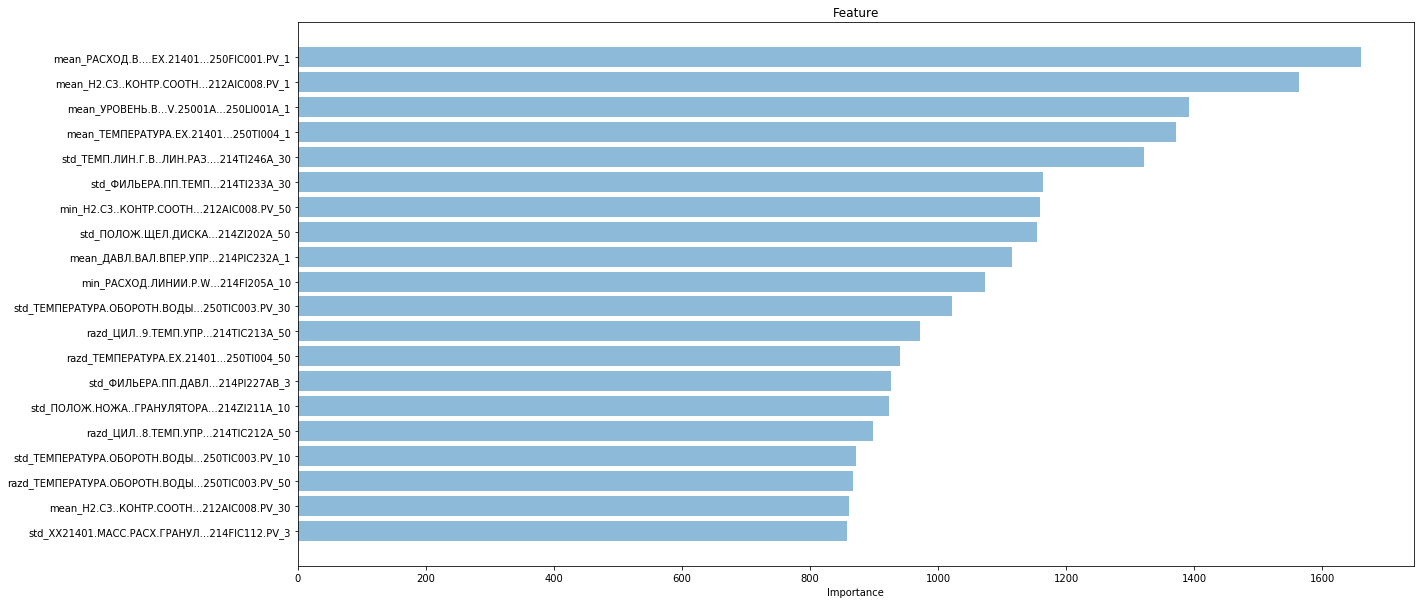

In [36]:
draw_importance(NAMES, model.feature_importance(), top_k=20)

In [133]:
def get_topk_features(x, x_mean, k=5):
    p = model.predict(np.array([x]))[0]
    imp = []
    for feature_id in np.argsort(model.feature_importance())[-100:]:
        xc = x.copy()
        xc[feature_id] = x_mean[feature_id]
        p1 = model.predict(np.array([xc]))[0]
        imp.append((p - p1, NAMES[feature_id], feature_id))
    
    return p, sorted(imp, reverse=True)[:5]


# get_topk_features(make_features(df)[1])

In [183]:
def get_by_date(date, csv_path):
    """
    :param date: timedate in hours
    """
    
    date_range = (df.date >= date) & (df.date < (date + timedelta(minutes=240)))
    dates = list(df[date_range].date)
    xvalues = []
    rvalues = []
    k = 5
    
    xs = []
    for dt in tqdm.tqdm(dates):
        x = make_features(df[make_range(df, dt - timedelta(minutes=M_PRED_BEFORE_SPAN))])[1]
        xs.append(x)
    x_mean = np.mean(xs, axis=0)
    
    ps = []
    ass = []
    for dt, x in zip(tqdm.tqdm(dates), xs):
        fs = []
        p, features = get_topk_features(x, x_mean, k=k)
        ps.append(p)
        for a, _, f_i in features:
            fs.append(f_i)
        
        xvalues.append(x)
        rvalues.append(fs)
        
    ddf = pd.DataFrame(
        dates,
        index=list(range(len(dates))),
        columns=['date']
    )
    
    xdf = pd.DataFrame(
        xvalues
    )
    xdf = pd.concat([ddf, xdf], axis=1)
    xdf.to_csv('xxx' + csv_path, index=None)
    
    rdf = pd.DataFrame(
        rvalues,
        columns=[f'top{i}_feature' for i in range(1, k + 1)]
    )
    rdf = pd.concat([ddf, rdf], axis=1)
    rdf.to_csv(csv_path, index=None)
    
    pdf = pd.DataFrame(
        ps,
        columns=['prob']
    )
    
    pdf.to_csv('ppp' + csv_path, index=None)
    
    return ps

In [203]:
stops.iloc[:20]

,date,type
0,2017-11-01 11:03:00,stop
1,2017-01-30 08:51:00,stop
2,2017-02-24 17:45:00,stop
3,2017-07-03 00:16:00,stop
4,2017-08-03 11:23:00,vibrosito
5,2017-08-03 15:56:00,vibrosito
6,2017-10-03 17:55:00,stop
7,2017-03-31 01:42:00,vibrosito
8,2017-01-04 07:45:00,stop
9,2017-03-04 20:48:00,stop


In [184]:
# date, csv_path = parser.parse('2017-11-01 09:10'), 'sasha.csv'
date, csv_path = parser.parse('2017-06-10 01:00'), 'sasha.csv'
date

datetime.datetime(2017, 6, 10, 1, 0)

In [185]:
p = get_by_date(date, csv_path)
p[:4]

100%|██████████| 1440/1440 [06:38<00:00,  3.61it/s]


[0.38793454122486565,
 0.5406137691093803,
 0.47418465772496232,
 0.5455462893959665]

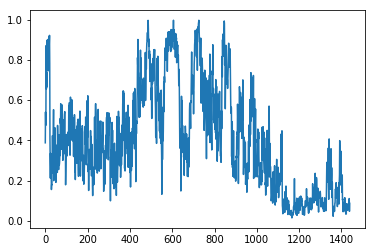

In [186]:
plt.plot(p)

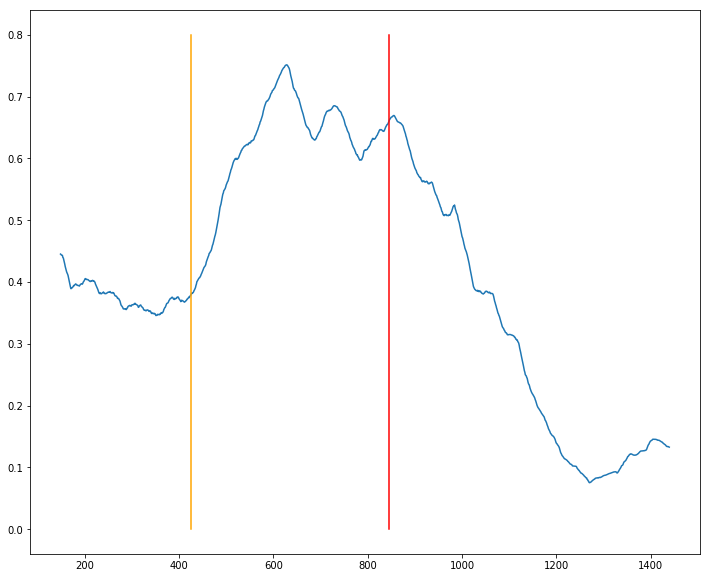

In [215]:
plt.figure(figsize=(12, 10))
pd.Series(p).rolling(150).mean().plot();
plt.plot([426, 426], [0, 0.8], color='orange');
plt.plot([846, 846], [0, 0.8], color='r');
plt.savefig('ptimeplot1.png');